# (1) Manual Data Cleaning and Engineering

This introductory notebook focuses on the following aspects of a data processing pipeline, and hopefully proves that these steps are vital to any data application:
* **Data Insights & Visualizations**
* **Data Cleaning**
* **Data Imputation**
* **Manual Feature Engineering**

In [1]:
import numpy as np
import pandas as pd
from utils import groupby_and_gather, age_to_age_bucket, unknown_to_nan
from imputers import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style("white", {'ytick.major.size': 8.0})
sns.set_context("poster", font_scale=0.8)

## Reading & Getting to Know the Data
Let's read in data and observe the kind of information we are being given.

In [2]:
date_variables = ['date_account_created', 'timestamp_first_active', 'date_first_booking']
users_df = pd.read_csv('(0)data/train_users.csv', parse_dates=date_variables)
users_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaT,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaT,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [3]:
users_test_df = pd.read_csv('(0)data/test_users.csv', parse_dates=date_variables)
users_test_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,2014-07-01 00:00:06,NaT,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,2014-07-01 00:00:51,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,2014-07-01 00:01:48,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome
3,6c6puo6ix0,2014-07-01,2014-07-01 00:02:15,NaT,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,IE
4,czqhjk3yfe,2014-07-01,2014-07-01 00:03:05,NaT,-unknown-,NaN,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Safari


In [4]:
sessions_df = pd.read_csv('(0)data/sessions.csv')
sessions_df.head()

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,NaN,NaN,Windows Desktop,435.0


In [5]:
countries_df = pd.read_csv('(0)data/countries.csv', index_col='country_destination')
countries_df.head()

,lat_destination,lng_destination,distance_km,destination_km2,destination_language,language_levenshtein_distance
country_destination,,,,,,
AU,-26.853388,133.275160,15297.7440,7741220.0,eng,0.00
CA,62.393303,-96.818146,2828.1333,9984670.0,eng,0.00
DE,51.165707,10.452764,7879.5680,357022.0,deu,72.61
ES,39.896027,-2.487694,7730.7240,505370.0,spa,92.25
FR,46.232193,2.209667,7682.9450,643801.0,fra,92.06


In [6]:
buckets_df = pd.read_csv('(0)data/age_gender_bkts.csv', parse_dates=['year'])
buckets_df.head()

,age_bucket,country_destination,gender,population_in_thousands,year
0,100+,AU,male,1.0,2015.0
1,95-99,AU,male,9.0,2015.0
2,90-94,AU,male,47.0,2015.0
3,85-89,AU,male,118.0,2015.0
4,80-84,AU,male,199.0,2015.0


## Data Insights & Visualizations 
Here we will investigate some common questions such as:
* What percentage of missing data do we have for each column?
* Are all missing values correctly represented in a way that can `pandas` can interpret them as NaNs?
* Are there serious outliers in the data that could potentially affect performance?
* Do we need to drop unrelated columns, fix values, and do other common cleaning operations to make sense of data?
* Are there easily identifiable patterns via graphs and plots? How complex is the data at hand?
* Do we have a balanced dataset or an imbalanced dataset?

It could be argued that the aim of automated feature engineering should be to minimize our attemps to visualize these patterns and observations ourselves, but as will be shown later, it seems that these basic operation still come in handy.

In [7]:
print("We have", users_df.shape[0], "users in the training set and", users_test_df.shape[0], "in the test set.")
print("In total we have", users_df.shape[0] + users_test_df.shape[0], "users.")
# Display missing data percentages per column (%)
all_users = pd.concat((users_df, users_test_df), axis=0, ignore_index=True, sort=False)
nan_percentages = (all_users.isnull().sum() / all_users.shape[0]) * 100
nan_percentages[nan_percentages > 0]

We have 213451 users in the training set and 62096 in the test set.
In total we have 275547 users.


date_first_booking         67.733998
age                        42.412365
first_affiliate_tracked     2.208335
country_destination        22.535538
dtype: float64

In [8]:
all_users['age'].describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

In [9]:
all_users['gender'].value_counts()

-unknown-    129480
FEMALE        77524
MALE          68209
OTHER           334
Name: gender, dtype: int64

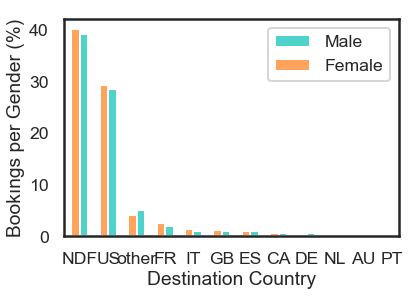

In [10]:
# Plot gender distributions for each country destination
women, men = sum(all_users['gender'] == 'FEMALE'), sum(all_users['gender'] == 'MALE')
female_destinations = all_users.loc[all_users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = all_users.loc[all_users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

male_destinations.plot(kind='bar', width=0.3, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=0.3, color='#FFA35D', position=1, label='Female', rot=0)
plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Bookıngs per Gender (%)')
plt.show()

Text(0, 0.5, 'Bookings (%)')

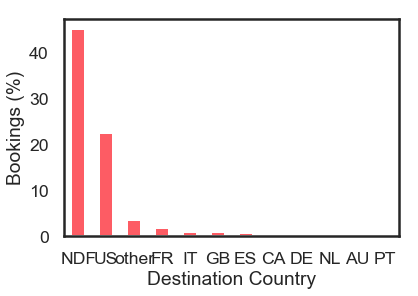

In [11]:
# Plot travel distributions
destination_percentage = all_users.country_destination.value_counts() / all_users.shape[0] * 100
destination_percentage.plot(kind='bar',color='#FD5C64', rot=0)
plt.xlabel('Destination Country')
plt.ylabel('Bookings (%)')

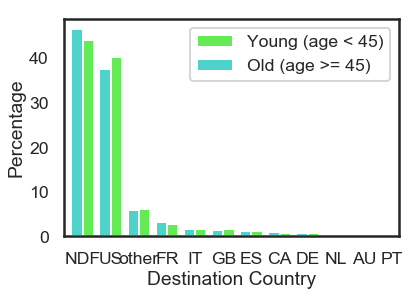

In [12]:
age_threshold = all_users['age'].median()
younger = sum(all_users.loc[all_users['age'] < age_threshold, 'country_destination'].value_counts())
older = sum(all_users.loc[all_users['age'] >= age_threshold, 'country_destination'].value_counts())
younger_destinations = all_users.loc[all_users['age'] < age_threshold, 'country_destination'].value_counts() / younger * 100
older_destinations = all_users.loc[all_users['age'] >= age_threshold, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=0.4, color='#63EA55', position=0, label='Young (age < 45)', rot=0)
older_destinations.plot(kind='bar', width=0.4, color='#4DD3C9', position=1, label='Old (age >= 45) ', rot=0)
plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
plt.show()

## Data Cleaning
Chances are that we will have to do some manual data processing no matter the quality and the quantity of the packages or utilities we have used for data processing. For example: 

* The 'date_first_booking' column for the test data frame column are all missing (NaN). While using the open source Python package `h2o`, we will have to make sure that we don't pass any empty columns to it.
* Often data sets contain different representations (such as empty character '', strings like 'UNKNOWN' or 'EMPTY') and a function that could be found in `utils.py` may come in handy. This is the case with the data frames we use, and the `head()` statements above showcase this.
* As observed in the previous section, age columns contains some seriously illogical values. Simply setting these outlier ages (say > 110) to a threshold (say 110) could be a bad approach. A better approach would be to completely remove these cases, and this works in this example as there are only 779 users whose age is greater than 110 (a relatively low number when compared to the data we have). Note that as we don't want to lose any test cases, we will instead set outlier values to NaN (missing values) in test set.

In [13]:
# Remove variables that are all empty for either the training or test sets
users_df.drop('date_first_booking', axis=1, inplace=True)
users_test_df.drop('date_first_booking', axis=1, inplace=True)
# Convert arbitrary unknown values and representations to np.nan for uniformity
users_df, users_test_df = unknown_to_nan(df=users_df), unknown_to_nan(df=users_test_df)
# Remove rows with ages that don't make sense from training set
users_df = users_df[((users_df['age'] >= 15) & (users_df['age'] <= 110)) | (users_df['age'].isnull())]
# Set illogical ages to NaN values to be imputed for testing set
users_test_df['age'] = users_test_df['age'].apply(lambda x: np.nan if x > 110 else x)
users_test_df['age'] = users_test_df['age'].apply(lambda x: np.nan if x < 15 else x)

### Outlier Removal
Outlier removal should always be a viable question in data science problems. They could be introduced by measurement errors, type (cm, m, kg) conversion mistakes, equipment error, or they could simply be *over-represented* or *under-represented* rare-cases in a small sample size. Depending on their nature, outlier removal could either increase the accuracy of model allowing it to generalize better, or it could completely wreck training preventing the model from seeing the bigger picture. Although we won't be going down this road for the problem at hand due to low number of numerically representable variables and the difficulty of defining outliers due to a large feature space, below is some general information.

Outlier removal methods can be breaken down into two: i) *univariate* and ii) *multivariate*. Univariate methods include **Tukey's Fences (w/ IQR)**, **Median Absolute Deviation (MAD) Strategy**, and **Z-Score Testing**. Notice that most of these methods rely on the assumption that the feature vector is *normally distributed*. Applying these methods to columns (individually) would result in a huge loss of data, and of course categorical variables will be immune to these methods. Hence, the machine learning literature (under the domain name of *anomaly detection*) relies on multivariate methods such as **Gaussian Mixture Model (GMM)**, **Probabilistic Principal Component Analysis (PPCA)**, and **Local Outlier Factor (LOF)**. A more comphresensive analysis and survey of the literature can be found in *A comparative evaluation of outlier detection algorithms: experiments and analyses* by Remi Domingues et al. Moreover, the Python package `pyOD` [(check docs)](https://pyod.readthedocs.io) covers most of the modern approaches mentioned in the literature.

Moreover, `h2o` framework has an implementation of [Isolation Forest](http://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/if.html) which is primarily used for anomaly detection.

## Data Imputation
Data imputation is an interesting and a surprisingly broad subject. Depending on the model type we are using, it is sometimes borderline necessary to perform data imputation as the model can't handle missing data. One common example is the **Support Vector Machines (SVM)** in R and Python. (NOTE: There exists different versions of this algorithm that *could* handle missing data but these are not supported by the mainstream packages yet.) Or, it could be the case that our model handles missing data, but it does so by assuming that *unknown* values are also seperate cases. Two common examples are some of the implementations of **Random Forest** and **Boosting** algorithms. (NOTE: Traditionally some algorithms work better with missing values than others; e.g. XGBoost) More could be read about the underlying theory in *Missing Data Analysis: Making It Work in the Real World* by John W. Graham. Moreover, the [docs](http://docs.h2o.ai/driverless-ai/latest-stable/docs/userguide/missing-values-handling.html) of `h2o` suggests that certain models included in the framework apply different types of imputation strategies when handling missing data. This might be problematic, as the model *leaderboard* `AutoML()` class displays make no mention of this whatsoever. This further adds motivation to this section.

One common approach taken for missing data imputation is taking either the **mean** and **median** of the columns instead of the NaN values for numerical variables and **mode** of categorical variables. Currently, data imputation functionalities of `sklearn` and `h2o` support only these simple univariate operations. (NOTE: The `IterativeImputer()` class in `sklearn` *was* an exception, but it seems like this class is currently out of the development cycle.) In *Best Practices for Missing Data Management in Counseling Psychology* by Gabriel L. Schlomer et al., authors noted that experts strongly advise against these methods as they heavily underestimate the variance and covariance (and correlations as a result). Here, this argument ties in with whether the missing patterns in the dataset are **MCAR** (missing completely at random), **MAR** (missing at random), and **MNAR** (missing not at random). Both mentioned papers include adequate definitions of these concepts, and we have also included a supplementary implementation of *Little's MCAR (Hypothesis) Test* in `utils.py`.

Roughly, the idea is that although simpler univariate methods add bias no matter what, their effect will be less when the data is missing completely at random. Nevertheless, the literature adapts solutions such as **Stochastic** and **Non-stochastic Regression**, **Expectization Maximization (EM)**, and perhaps more popularly **Multivariate Imputations by Chained Equations (MICE)**. Here, we include a more simpler and less time-consuming, yet still multi-variate, imputation method: **K-nearest Neighbours**. The source code can be found in `imputers.py`. Datetime features are ingored in the imputation for minimizing cost of computation.

In [14]:
missing_columns = users_df.columns[users_df.isnull().any()].values.tolist()
print("Columns with missing values are: ", missing_columns)
imputer = KNNImputer(k=7)
imputer.fit(df=users_df, 
            impute_variables=missing_columns,
            ignore_features=['id', 'date_account_created', 'timestamp_first_active', 'country_destination'])
users_df, users_test_df = imputer.impute(df=users_df), imputer.impute(df=users_test_df)

Columns with missing values are:  ['gender', 'age', 'first_affiliate_tracked', 'first_browser']


## Manual Feature Engineering
As we shall see, the uniqueness of `featuretools` comes from the way it applies to relational data sets, no matter how large they may be. Rather than leaving the tedious task of coming up with new features such as the *average time between two events* and *the overall trends seen in a users sign-ins* to the data scientist, `featuretools` aim to automate this process. Yet, there are also relations that can't be extracted with `featuretools` via its primitives. One such example is showcased below. In a *R-like pseudocodic language*, we will `join` 'age' and 'gender' columns in the training and testing data frames and map them to age buckets (ranges such as 45-49) with `age_to_age_bucket()` method that can be found in `utils.py`. Then, we will `join` on 'age_bucket' and 'gender' in buckets data frame and then perform `groupby` and `gather` operations. By comparing what we get below versus what we had for the buckets data frame, and it should be pretty clear how this new buckets data frame can link to the users training and test data frames with a **one-to-many** relationship. Values under each country columns represent the total population for that specific age-gender bucket. Fortunately, `featuretools` can handle the rest.

In [15]:
# Create age gender buckets in training & test data frames
users_df['age_gender_bucket'] = users_df['age'].apply(age_to_age_bucket) + \
                                users_df['gender'].apply(lambda x: x.lower())
users_test_df['age_gender_bucket'] = users_test_df['age'].apply(age_to_age_bucket) + \
                                     users_test_df['gender'].apply(lambda x: x.lower())
# Create age gender buckets in buckets data frame
buckets_df = groupby_and_gather(raw_df=buckets_df)
# Observe the manually engineered data frame
buckets_df.head()

## Save Progress
With this introductory notebook, our saved data is gone through imputation, cleaning (to the extent of our knowledge without any domain expertise), and features that are manually engineered.

In [ ]:
users_df.to_csv('(1)data_manual_ops/train_users.csv', index=None)
users_test_df.to_csv('(1)data_manual_ops/test_users.csv', index=None)
buckets_df.to_csv('(1)data_manual_ops/age_gender_bkts.csv', index=None)